In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import LayoutLMv2Processor, LayoutLMForTokenClassification, AdamW, BertForTokenClassification,\
    BertTokenizer, LayoutLMTokenizer, AutoTokenizer
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
from copy import deepcopy

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.model.trainer import BertTrainer, LayoutLMTrainer
import warnings
warnings.filterwarnings("ignore")

/users/eleves-a/2022/sabrina.lomelino-sartori/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [4]:
model_name = "few_shot_learning"
dataset_name = "sroie"

In [5]:
logging.basicConfig(filename='logs/few_shot_learning_cord.log', encoding='utf-8', level= logging.INFO)

## Obtaining data

In [6]:
dataset = load_dataset("darentang/sroie")

Extracting data files: 100%|██████████| 1/1 [00:11<00:00, 11.42s/it]
Generating train split: 626 examples [00:01, 601.23 examples/s]
Generating test split: 347 examples [00:00, 535.26 examples/s]


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 626
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 347
    })
})

In [8]:
dataset['train'].features['ner_tags'].feature.names

['O',
 'B-COMPANY',
 'I-COMPANY',
 'B-DATE',
 'I-DATE',
 'B-ADDRESS',
 'I-ADDRESS',
 'B-TOTAL',
 'I-TOTAL']

In [9]:
n_classes = len(dataset['train'].features['ner_tags'].feature.names)
n_classes

9

In [10]:
bert_tokenizer =AutoTokenizer.from_pretrained("bert-base-uncased")

In [11]:
llm_tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutlm-base-uncased",)

## BERT

In [12]:
train_dataset = ImageLayoutDataset(
    dataset['train'], 
    tokenizer=bert_tokenizer
)

  0%|          | 0/626 [00:00<?, ?it/s]

100%|██████████| 626/626 [00:03<00:00, 174.82it/s]


In [13]:
validation_dataset = ImageLayoutDataset(
    dataset['test'],
    tokenizer= bert_tokenizer
)

  0%|          | 0/347 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:01<00:00, 176.54it/s]


In [14]:
device = "cuda"

In [15]:
n = len(train_dataset)
history= {}

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle = False
)

for i in range(8):
    num_samples = n//2**i

    train_dataloader = DataLoader(
        train_dataset[0: num_samples],
        batch_size=2,
        shuffle = False
    )

    bert = BertForTokenClassification\
        .from_pretrained(
            'bert-base-uncased', 
            num_labels = n_classes
        )
    
    bert.to(device)

    trainer = BertTrainer(
        bert
    )

    print(f"training {trainer.model_name} with {num_samples} samples")

    trainer.compile(
        train_dataloader,
        validation_dataloader,
        n_classes= n_classes,
        device = "cuda"
    )

    history[num_samples] = trainer.history

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 626 samples


100%|██████████| 10/10 [03:47<00:00, 22.79s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 313 samples


100%|██████████| 10/10 [02:12<00:00, 13.21s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 156 samples


100%|██████████| 10/10 [01:23<00:00,  8.37s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 78 samples


100%|██████████| 10/10 [01:00<00:00,  6.02s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 39 samples


100%|██████████| 10/10 [00:48<00:00,  4.80s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 19 samples


100%|██████████| 10/10 [00:41<00:00,  4.19s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 9 samples


100%|██████████| 10/10 [00:39<00:00,  3.90s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 4 samples


100%|██████████| 10/10 [00:37<00:00,  3.74s/it]


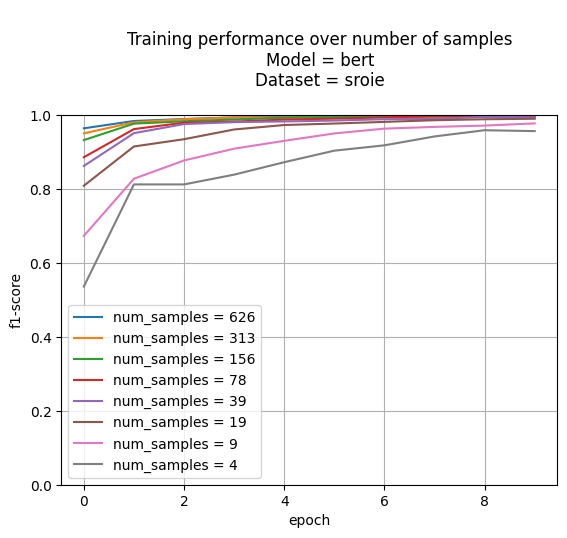

In [16]:
for k in history.keys():
    data = history[k]['train-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}"
    )

plt.title(f'''
    Training performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

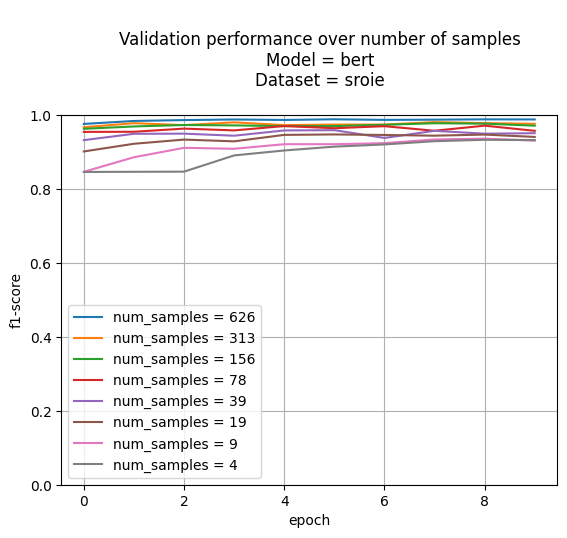

In [17]:
for k in history.keys():
    data = history[k]['validation-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}"
    )

plt.title(f'''
    Validation performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

## LayoutLM

In [18]:
train_dataset = ImageLayoutDataset(
    dataset['train'], 
    tokenizer=llm_tokenizer
)

100%|██████████| 626/626 [00:03<00:00, 177.41it/s]


In [19]:
validation_dataset = ImageLayoutDataset(
    dataset['test'],
    tokenizer= llm_tokenizer
)

  0%|          | 0/347 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:01<00:00, 177.07it/s]


In [20]:
device = "cuda"

In [21]:
n = len(train_dataset)
history_layoutlm= {}

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle = False
)

for i in range(8):
    num_samples = n//2**i

    train_dataloader = DataLoader(
        train_dataset[0: num_samples],
        batch_size=2,
        shuffle = False
    )

    layoutlm = LayoutLMForTokenClassification\
        .from_pretrained(
            'microsoft/layoutlm-base-uncased', 
            num_labels = n_classes
        )
    
    layoutlm.to(device)

    trainer = LayoutLMTrainer(
        layoutlm
    )

    print(f"training {trainer.model_name} with {num_samples} samples")

    trainer.compile(
        train_dataloader,
        validation_dataloader,
        n_classes= n_classes,
        device = "cuda"
    )

    history_layoutlm[num_samples] = trainer.history

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training LayoutLM with 626 samples


100%|██████████| 10/10 [03:50<00:00, 23.06s/it]
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training LayoutLM with 313 samples


100%|██████████| 10/10 [02:13<00:00, 13.35s/it]
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training LayoutLM with 156 samples


100%|██████████| 10/10 [01:25<00:00,  8.52s/it]
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training LayoutLM with 78 samples


100%|██████████| 10/10 [01:01<00:00,  6.11s/it]
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training LayoutLM with 39 samples


100%|██████████| 10/10 [00:49<00:00,  4.90s/it]
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training LayoutLM with 19 samples


100%|██████████| 10/10 [00:42<00:00,  4.26s/it]
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training LayoutLM with 9 samples


100%|██████████| 10/10 [00:39<00:00,  3.95s/it]
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training LayoutLM with 4 samples


100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


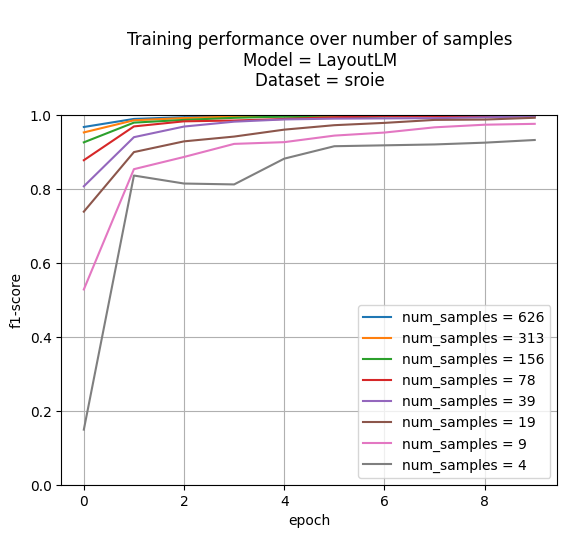

In [22]:
for k in history_layoutlm.keys():
    data = history_layoutlm[k]['train-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}"
    )

plt.title(f'''
    Training performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

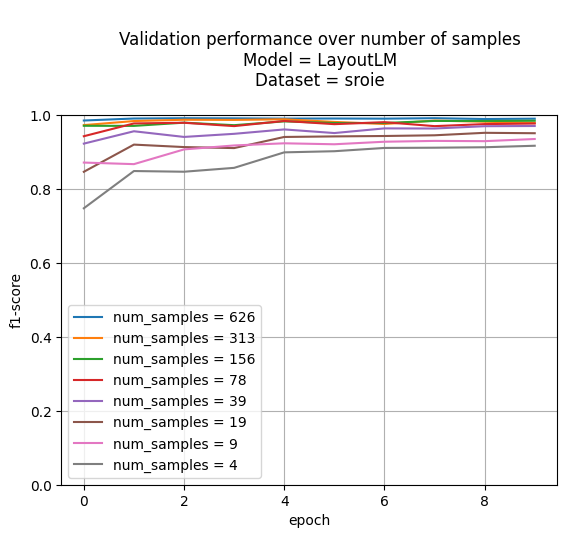

In [23]:
for k in history_layoutlm.keys():
    data = history_layoutlm[k]['validation-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}"
    )

plt.title(f'''
    Validation performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

## Finetuning results 

In [ ]:
train_dataset = ImageLayoutDataset(
    dataset['train'], 
    tokenizer=llm_tokenizer
)
validation_dataset = ImageLayoutDataset(
    dataset['test'],
    tokenizer= llm_tokenizer
)
device = "cuda"
n = len(train_dataset)
history_layoutlm= {}

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle = False
)

experiments = [2,5,10]

for num_samples in experiments:
    train_dataloader = DataLoader(
        train_dataset[0: num_samples],
        batch_size=2,
        shuffle = False
    )

    layoutlm = LayoutLMForTokenClassification\
        .from_pretrained(
            'microsoft/layoutlm-base-uncased', 
            num_labels = n_classes
        )
    
    layoutlm.to(device)

    trainer = LayoutLMTrainer(
        layoutlm
    )

    print(f"training {trainer.model_name} with {num_samples} samples")

    trainer.compile(
        train_dataloader,
        validation_dataloader,
        n_classes= n_classes,
        device = "cuda"
    )

    history_layoutlm[num_samples] = trainer.history

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 1056.60it/s]
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training layoutlm v1 with 2 samples


100%|██████████| 1/1 [00:00<00:00, 10.51it/s]
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training layoutlm v1 with 5 samples


100%|██████████| 3/3 [00:00<00:00, 13.77it/s]
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training layoutlm v1 with 10 samples


100%|██████████| 5/5 [00:00<00:00,  9.33it/s]


In [ ]:
for k in history_layoutlm.keys():
    print(f"{k} shots -- f1 :  {np.max(history_layoutlm[k]['validation-f1'])}")

2 shots -- f1 :  0.4529262185096741
5 shots -- f1 :  0.5593723654747009
10 shots -- f1 :  0.711620032787323
